#### import libraries

In [1]:
import numpy as np
import pandas as pd 
import re
import geonamescache
import unidecode
import json
from mpl_toolkits.basemap import Basemap
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import Image

#### import all headlines for the file

In [2]:
f = open('./data/headlines.txt',"r")
headlines = f.read().splitlines()
f.close()

#### create dictionaries for countries and cities

In [3]:
gc = geonamescache.GeonamesCache()

countries = [country["name"] for country in gc.get_countries().values()]
cities = [city["name"] for city in gc.get_cities().values()]
allcountries = gc.get_countries()

#### create mappings between accented and unicode countries and city names

In [4]:
country_accent_mapping = {
    unidecode.unidecode(country): country for country in countries
}

city_accent_mapping = {
    unidecode.unidecode(city): city for city in cities
}

##### create mappings between country code and country name 

In [5]:
country_to_code = {
    allcountries[country]['name']: country for country in allcountries
}

code_to_country = {
    country: allcountries[country]['name'] for country in allcountries
}

#### sort countries and cities by name lenght

In [6]:
unaccented_cities = list(city_accent_mapping.keys())
unaccented_countries = list(country_accent_mapping.keys())

unaccented_cities.sort(key=lambda item: (-len(item), item), reverse=False)
unaccented_countries.sort(key=lambda item: (-len(item), item), reverse=False)

#### create regexes for coutries and city names

In [7]:
_cities = "|".join(unaccented_cities)
regexCity = "\\b(" + _cities + ")\\b"
compiledReCity = re.compile(regexCity)

_countries = "|".join(unaccented_countries)
regexCountry = "\\b(" + _countries + ")\\b"
compiledReCountry = re.compile(regexCountry)

#### create function extracting city and country from a headline

In [8]:
def city_and_country_from_a_headline(headline):
    
    '''
    find city name and country name in a given headline
    
    input: headline (string)
    output: mapping the headline to city(s) and/or countries (dict)
    
    '''
    
    latitude = None
    longitude = None
    population = None
    
    # country found
    country_match = compiledReCountry.search(headline)
    if country_match:
        country = country_match.group(0)
    else:
        country = None
    
    # city found
    city_match = compiledReCity.search(headline)
    if city_match:
        city = city_match.group(0)
        # look up a country based on a accented city name
        _cities = gc.get_cities_by_name(city_accent_mapping[city])
        biggestCity = {}
        for c in _cities:
            for cityKey in c:
#                 print(cityKey)
                if len(biggestCity) == 0:
                    biggestCity = c[cityKey]
                else:
                    if c[cityKey]['population'] > biggestCity['population']:
                        biggestCity = c[cityKey] 
#         print(biggestCity)
        if not country_match:
            country = code_to_country[biggestCity['countrycode']]
        latitude = biggestCity['latitude']
        longitude = biggestCity['longitude']
        population = biggestCity['population']
    else:
        city = None
    
    return dict(headline=headline, country=country, city=city, latitude=latitude, longitude=longitude, population=population)    

#### test to see results for first 100 headlines

In [9]:
headline_cities_and_countries = [
    city_and_country_from_a_headline(headline) for headline in headlines
]
headline_cities_and_countries[-100:]

[{'headline': 'Zika case reported in Limoeiro',
  'country': 'Brazil',
  'city': 'Limoeiro',
  'latitude': -7.87472,
  'longitude': -35.45028,
  'population': 42328},
 {'headline': 'Ibadan tests new cure for Malaria',
  'country': 'Nigeria',
  'city': 'Ibadan',
  'latitude': 7.37756,
  'longitude': 3.90591,
  'population': 3565108},
 {'headline': 'Gonorrhea has Arrived in Avon Lake',
  'country': 'United States',
  'city': 'Avon Lake',
  'latitude': 41.50532,
  'longitude': -82.0282,
  'population': 23453},
 {'headline': 'Pneumonia has not Left Kinshasa',
  'country': 'Democratic Republic of the Congo',
  'city': 'Kinshasa',
  'latitude': -4.32758,
  'longitude': 15.31357,
  'population': 7785965},
 {'headline': 'Respiratory Syncytial Virus Hits Henderson',
  'country': 'United States',
  'city': 'Henderson',
  'latitude': 36.0397,
  'longitude': -114.98194,
  'population': 285667},
 {'headline': 'More Zika patients reported in Lakeland',
  'country': 'United States',
  'city': 'Lakela

##### save to  json

In [10]:
save_file = "./data/headline_cities_and_countries.json"
with open(save_file, "w") as fout:
    fout.write(json.dumps(headline_cities_and_countries))

#### save mappings

In [11]:
with open("./data/country_accent_mapping.json", "w") as fout:
    fout.write(json.dumps(country_accent_mapping))
with open("./data/city_accent_mapping.json", "w") as fout:
    fout.write(json.dumps(city_accent_mapping))
with open("./data/country_to_code.json", "w") as fout:
    fout.write(json.dumps(country_to_code))
with open("./data/code_to_country.json", "w") as fout:
    fout.write(json.dumps(code_to_country))

#### read df from json and print 10 first rows

In [12]:
data = pd.read_json("./data/headline_cities_and_countries.json")
data = data.replace({None: np.nan})

data.head(10)

,headline,country,city,latitude,longitude,population
0,Zika Outbreak Hits Miami,United States,Miami,25.77427,-80.19366,441003.0
1,Could Zika Reach New York City?,United States,New York City,40.71427,-74.00597,8175133.0
2,First Case of Zika in Miami Beach,United States,Miami Beach,25.79065,-80.13005,92312.0
3,"Mystery Virus Spreads in Recife, Brazil",Brazil,Recife,-8.05389,-34.88111,1478098.0
4,Dallas man comes down with case of Zika,United States,Dallas,32.78306,-96.80667,1300092.0
5,Trinidad confirms first Zika case,Bolivia,Trinidad,-14.83333,-64.90000,84259.0
6,Zika Concerns are Spreading in Houston,United States,Houston,29.76328,-95.36327,2296224.0
7,Geneve Scientists Battle to Find Cure,Switzerland,Geneve,46.20222,6.14569,183981.0
8,The CDC in Atlanta is Growing Worried,United States,Atlanta,33.74900,-84.38798,463878.0
9,Zika Infested Monkeys in Sao Paulo,Brazil,Sao Paulo,-23.54750,-46.63611,10021295.0


#### remove duplicates

In [13]:
print(f"There were {len(data)} rows before dropping duplicates.")
data = data.drop_duplicates()
print(f"There are {len(data)} rows after dropping duplicates.")

There were 650 rows before dropping duplicates.
There are 648 rows after dropping duplicates.


#### check data

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 649
Data columns (total 6 columns):
headline      648 non-null object
country       606 non-null object
city          606 non-null object
latitude      606 non-null float64
longitude     606 non-null float64
population    606 non-null float64
dtypes: float64(3), object(3)
memory usage: 35.4+ KB


In [15]:
print('Missing Values:')
data.isna().sum()

Missing Values:


headline       0
country       42
city          42
latitude      42
longitude     42
population    42
dtype: int64

In [16]:
data['country'].value_counts()

United States     303
Brazil             21
United Kingdom     19
Philippines        19
Canada             15
                 ... 
Uruguay             1
Portugal            1
Armenia             1
Sweden              1
Gabon               1
Name: country, Length: 94, dtype: int64

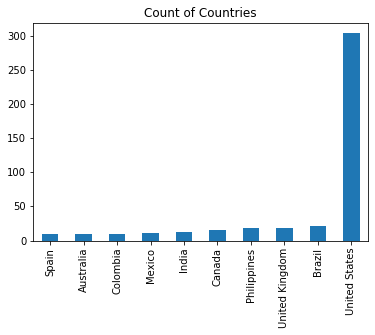

In [17]:
%matplotlib inline

_ = data['country'].value_counts().sort_values().tail(10).plot.bar(title='Count of Countries')

# Issue: most data is from US.

In [18]:
print(f'There are {data["country"].nunique()} different countries.')
print(f'There are {data["city"].nunique()} different cities.')

There are 94 different countries.
There are 573 different cities.


In [19]:
data["city"].value_counts().sort_values().tail(10)

Edinburgh    2
Albany       2
Orange       2
Richmond     2
Zanzibar     2
Jefferson    2
Madrid       3
Barcelona    3
Miami        4
Monroe       4
Name: city, dtype: int64

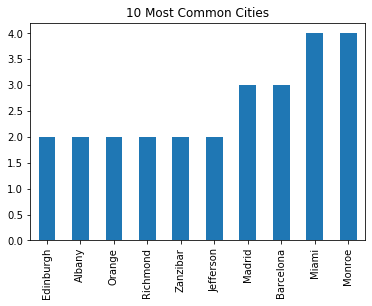

In [20]:
_ = (
    data["city"]
    .value_counts()
    .sort_values()
    .tail(10)
    .plot.bar(title="10 Most Common Cities")
)

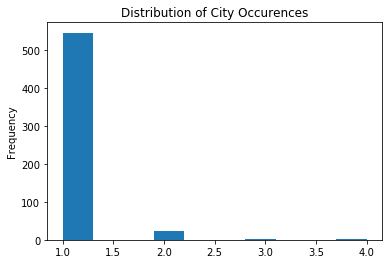

In [21]:
_ = data["city"].value_counts().plot.hist(title="Distribution of City Occurences")

#### clean data

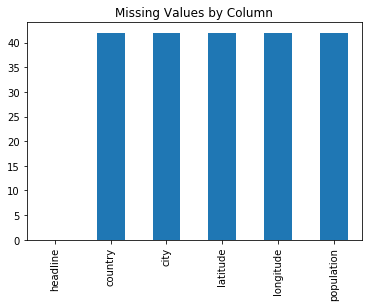

In [22]:
_ = data.isna().sum().plot.bar(title='Missing Values by Column')

In [23]:
pd.options.display.max_colwidth = 100

no_name = data[data["city"].isna()].copy()

print(f"There are {len(no_name)} headlines without a city.")


There are 42 headlines without a city.


#### remove rows with no city

In [24]:
data = data.dropna(subset=['city'])

In [25]:
print(f'We have the city locations for {len(data)} cities.')

We have the city locations for 606 cities.


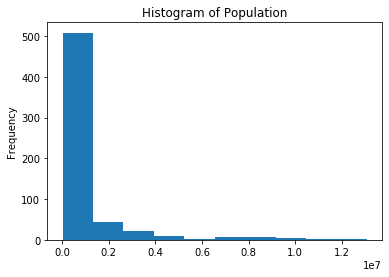

In [26]:
_ = data['population'].plot.hist(title='Histogram of Population')

#### initial map plot

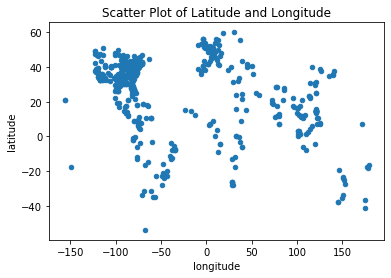

In [27]:
_ = data.plot.scatter(
    x="longitude", y="latitude", title="Scatter Plot of Latitude and Longitude"
)

#### plot it on map

In [28]:
map_plotter = Basemap()

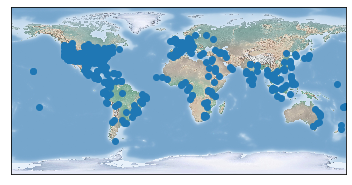

In [29]:
map_plotter.scatter(data["longitude"], data["latitude"], latlon=True)
map_plotter.shadedrelief()

#### create helper functions

In [30]:
def cluster_location(clusterer, data, lat_string="latitude", lon_string="longitude"):
    """
    Fit a clustering algorithm on location data.
    """
    features = data[[lat_string, lon_string]].copy()
    clusterer.fit(features)
    # Assign the cluster labels
    data["cluster"] = clusterer.labels_
    return data

In [31]:
def plot_clusters(data):
    """
    Plot clustered data on a basemap.
    """
    plt.figure(figsize=(16, 10))
    m.shadedrelief()

    # Iterate through each cluster and plot
    for cluster, grouped in data.groupby("cluster"):
        if cluster == -1:
            # Handle the unassigned headlines
            plt.scatter(
                grouped["x"],
                grouped["y"],
                s=60,
                alpha=0.8,
                marker="o",
                label=f"Cluster: None",
                c="k",
            )
        else:
            plt.scatter(
                grouped["x"],
                grouped["y"],
                s=60,
                alpha=0.8,
                marker="o",
                label=f"Cluster: {cluster}",
            )

    # Add a legend and title (put legend to right of plot)
    ax = plt.gca()
    ax.legend(loc=(1, 0))
    _ = ax.set_title("Locations of Headlines", size=20)

#### plot clusters on a map

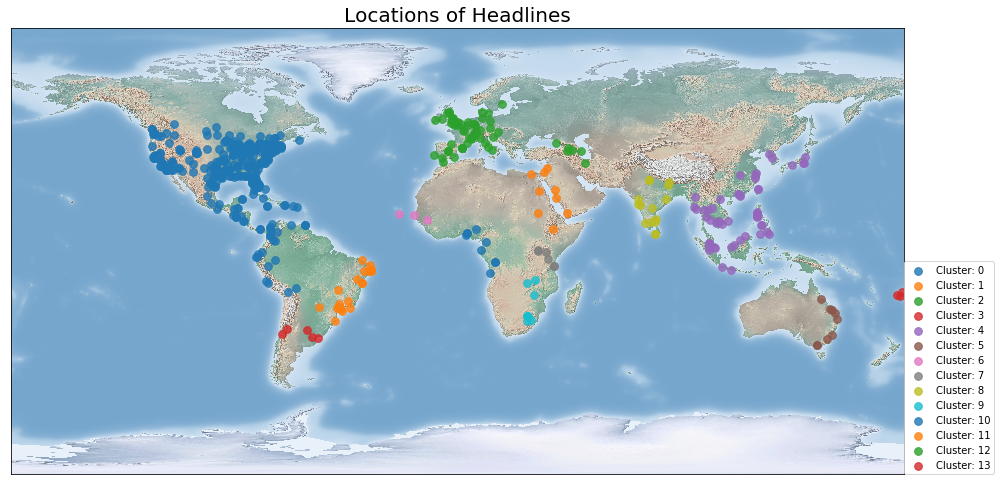

In [32]:
m = Basemap()
x, y = m(x=data["longitude"], y=data["latitude"])
data["x"], data["y"] = x, y
best_clusterer = DBSCAN(eps=9, metric="euclidean", min_samples=3)
data = cluster_location(best_clusterer, data)
plot_clusters(data[data['cluster'] != -1])
plt.savefig('../entire_world_clustering.png')

#### refine clustering

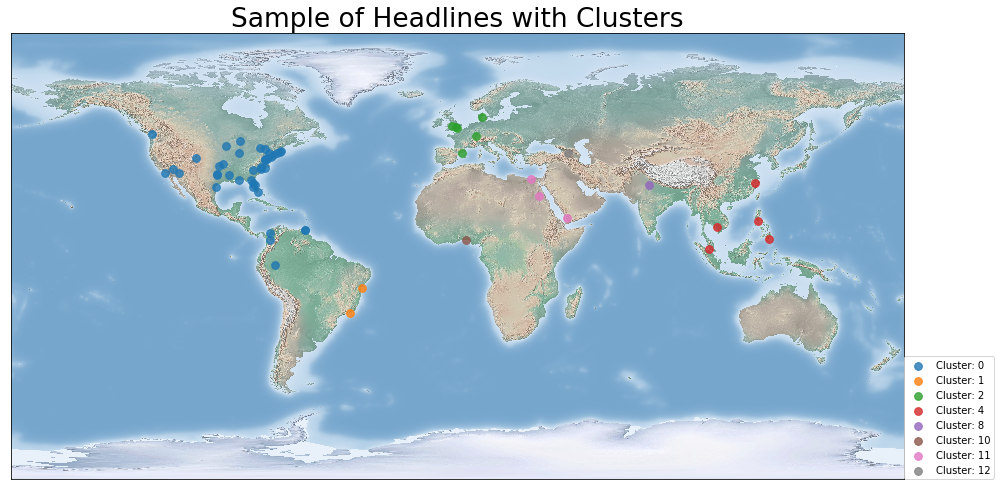

In [33]:
plot_clusters(data[data['cluster'] != -1].sample(frac=0.10))
ax = plt.gca()
plt.rcParams['font.size'] = 22
ax.set_title('Sample of Headlines with Clusters');

#### check cluster distribution (most data is from US, so clustering is skewed)

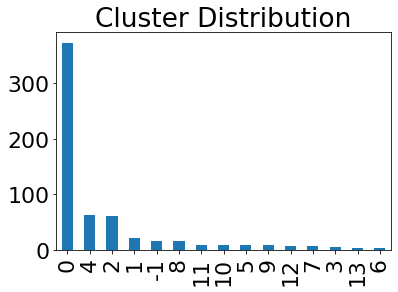

In [34]:
_ = data['cluster'].value_counts().plot.bar(title='Cluster Distribution')